This notebook is based on `https://github.com/higgsfield-ai/higgsfield/rl/rl_adventure_2/3.ppo.ipynb`

In [1]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation

import numpy as np

from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import davinci_code_env_v2

<h2>Neural Network</h2>

In [4]:
from actor_critic import ActorCritic

<h2>Use CUDA</h2>

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


<h2>Create Environments</h2>

In [6]:
def make_env(render_mode=None):
    env = gym.make(
        "DavinciCode-v2",
        render_mode=render_mode,
        # max_episode_steps=100,
        num_players=3,
        # initial_player=0,
        max_tile_num=12,
        initial_tiles=4,
    )
    return env


train_env = make_env()
eval_env = make_env()

<h2>Evaluation</h2>

In [7]:
def plot(frame_idx, rewards, corrects, invalids):
    clear_output(True)

    # Apply Gaussian filter
    sigma = 4
    rewards_smooth = gaussian_filter1d(rewards, sigma)
    invalids_smooth = gaussian_filter1d(invalids, sigma)
    corrects_smooth = gaussian_filter1d(corrects, sigma)

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title(f"frame {frame_idx}. reward: {rewards[-1]:.2f}")
    plt.plot(rewards, label="Reward")
    plt.plot(rewards_smooth, label="Smoothed Reward")
    plt.legend()

    plt.subplot(132)
    plt.title(f"frame {frame_idx}. correct: {corrects[-1]:.2f}. invalid: {invalids[-1]:.2f}")
    plt.plot(corrects, label="Correct")
    plt.plot(corrects_smooth, label="Smoothed Correct")
    plt.plot(invalids, label="Invalid")
    plt.plot(invalids_smooth, label="Smoothed Invalid")
    plt.legend()

    plt.show()


def eval_model(model, eval_env, print_info=False):
    # with torch.no_grad():
    state, _ = eval_env.reset()
    done = False
    total_reward = 0
    correct_guess_count = 0
    invalid_action_count = 0
    frame_count = 0
    while not done:
        state = torch.FloatTensor(state).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().item()
        if print_info:
            print(f"action: {action}")
        next_state, reward, terminated, truncated, info = eval_env.step(
            action
        )
        if print_info:
            print(f"action_mask: {next_state[1]}")
            print(f"reward: {reward}, terminated: {terminated}, truncated: {truncated}, info: {info}")
        done = np.logical_or(terminated, truncated)
        state = next_state
        total_reward += reward
        if info["correct_guess"]:
            correct_guess_count += 1
        if info["invalid_action"]:
            invalid_action_count += 1
        frame_count += 1
    return frame_count, total_reward, correct_guess_count, invalid_action_count

<h2>GAE</h2>

In [8]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [9]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids], log_probs[rand_ids], returns[
            rand_ids
        ], advantage[rand_ids]


def ppo_update(
    model,
    optimizer,
    ppo_epochs,
    mini_batch_size,
    states,
    actions,
    log_probs,
    returns,
    advantages,
    clip_param=0.2,
):
    # torch.autograd.set_detect_anomaly(True)
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(
            mini_batch_size, states, actions, log_probs, returns, advantages
        ):
            dist, value = model(state)
            entropy = dist.entropy()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [10]:
num_inputs = train_env.observation_space.shape[0]
num_outputs = train_env.action_space.n

# Hyper params:
shared_sizes = []
critic_sizes = [512, 256, 128, 64, 64, 32, 32, 32]
actor_sizes = [512, 256, 128, 64, 64, 64, 128, 256]
lr = 3e-4
num_steps = 500
mini_batch_size = 100
ppo_epochs = 3
threshold_reward = 200
gae_gamma = 0.99
gae_tau = 0.95

save_model = True

model = ActorCritic(num_inputs, num_outputs, shared_sizes, critic_sizes, actor_sizes).to(device)
# model = torch.load("./ppo_model_saves/ppo_model_final.pth")
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
max_frames = 1000000
# max_frames = np.inf
frame_count = 0
test_rewards = []
corrects = []
invalids = []

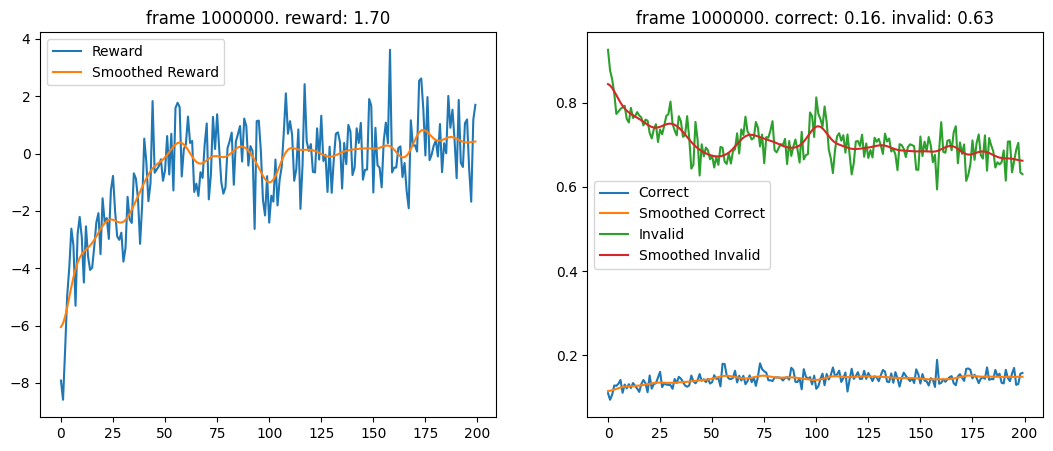

In [12]:
state, _ = train_env.reset()
early_stop = False

while frame_count < max_frames and not early_stop:

    log_probs = []
    values = []
    states = []
    actions = []
    rewards = []
    masks = []
    entropy = 0

    for step_num in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            dist, value = model(state)

        action = dist.sample()
        next_state, reward, terminated, truncated, _ = train_env.step(
            action.cpu().numpy()
        )
        done = np.logical_or(terminated, truncated)

        log_prob = dist.log_prob(action)
        entropy += dist.entropy()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor(reward, dtype=torch.float32).to(device))
        masks.append(torch.tensor(1 - done).to(device))

        states.append(state)
        actions.append(action)

        state = next_state
        frame_count += 1

        if done:
            state, _ = train_env.reset()

        if frame_count % 5000 == 0:
            eval_results = np.array([eval_model(model, eval_env) for _ in range(10)])
            test_total_frames = np.sum(eval_results[:, 0])
            test_reward = np.mean(eval_results[:, 1])
            correct_guess_rate = np.sum(eval_results[:, 2]) / test_total_frames
            invalid_action_rate = np.sum(eval_results[:, 3]) / test_total_frames
            test_rewards.append(test_reward)
            corrects.append(correct_guess_rate)
            invalids.append(invalid_action_rate)
            plot(frame_count, test_rewards, corrects, invalids)

            if test_reward > threshold_reward:
                early_stop = True

        if save_model and frame_count % 50000 == 0:
            eval_results = np.array([eval_results for _ in range(30)])
            test_total_frames = np.sum(eval_results[:, 0])
            test_reward = np.mean(eval_results[:, 1])
            correct_guess_rate = np.sum(eval_results[:, 2]) / test_total_frames
            invalid_action_rate = np.sum(eval_results[:, 3]) / test_total_frames
            torch.save(
                model,
                f"./ppo_model_saves/ppo_model_frame{frame_count}_reward{test_reward:.2f}_correct{correct_guess_rate:.2f}_invalid{invalid_action_rate:.2f}.pth",
            )

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values, gae_gamma, gae_tau)

    returns = torch.cat(returns).detach()
    log_probs = torch.stack(log_probs).detach().to(device)
    values = torch.cat(values).detach()
    states = torch.stack(states)
    actions = torch.tensor(actions).detach().to(device)

    advantage = returns - values

    ppo_update(
        model,
        optimizer,
        ppo_epochs,
        mini_batch_size,
        states,
        actions,
        log_probs,
        returns,
        advantage,
    )

In [13]:
train_env.close()
eval_env.close()

In [14]:
torch.save(
    model,
    f"./ppo_model_saves/ppo_model_frame{frame_count}_reward{test_reward:.2f}_correct{correct_guess_rate:.2f}_invalid{invalid_action_rate:.2f}.pth",
)

In [15]:
eval_env = make_env(render_mode="human")
# model = torch.load("./ppo_model_saves/ppo_model_final.pth", weights_only=False)
eval_results = eval_model(model, eval_env, True)
print("Evaluation results:")
print(f"frame_count: {eval_results[0]} | total_reward: {eval_results[1]} | correct_guess_count: {eval_results[2]} | invalid_action_count: {eval_results[3]}")
eval_env.close()

----------------
Current Player: 1

Player 1's tiles:
Tile 1: PRIVATE BLACK 4
Tile 2: PRIVATE WHITE 9
Tile 3: PRIVATE WHITE 10
Tile 4: PRIVATE WHITE 11
Tile 5: PRIVATE WHITE 12

Player 2's tiles:
Tile 1: PRIVATE WHITE 4
Tile 2: PRIVATE BLACK 6
Tile 3: PRIVATE WHITE 6
Tile 4: PRIVATE BLACK 10

Player 3's tiles:
Tile 1: PRIVATE WHITE 2
Tile 2: PRIVATE BLACK 5
Tile 3: PRIVATE BLACK 7
Tile 4: PRIVATE BLACK 9
----------------
action: 335
----------------
Current Player: 2

Player 2's tiles:
Tile 1: PRIVATE WHITE 4
Tile 2: PRIVATE BLACK 6
Tile 3: PRIVATE WHITE 6
Tile 4: PRIVATE BLACK 10

Player 3's tiles:
Tile 1: PRIVATE WHITE 2
Tile 2: PRIVATE BLACK 5
Tile 3: PRIVATE BLACK 7
Tile 4: PRIVATE BLACK 9

Player 1's tiles:
Tile 1: PRIVATE BLACK 4
Tile 2: PRIVATE WHITE 9
Tile 3: PRIVATE WHITE 10
Tile 4: PRIVATE WHITE 11
Tile 5: PRIVATE WHITE 12
----------------
action_mask: 0.0
reward: 0, terminated: False, truncated: False, info: {'current_player_index': 1, 'correct_guess': False, 'invalid_action